# HW_04 Problem #1

<img src="assets/Hull-Robert-HW-04-0f0ceaa4.png" width="600" />

### This Code was written by Robert 'Quinn' Hull, and borrowed elements from several other resources:
* Resources used to make HW_04 Problem #1:
  * The 'load CIFAR' dataset heavilty borrowed from pytorch tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
  * A refresher on the MLP borrowed from machine learning mastery - https://machinelearningmastery.com/neural-networks-crash-course/
  * Some code borrowed from medium . com about putting MLP into a pytorch - https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a
  * Some notes on regularization in MLP:
    * https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.5-Regularization.pdf
  * Very helpful for avoiding a blocker with batch_size dimensions. Be very careful with linear layers as the first parameter is batch_size, this is different than for convolutional layers
    * https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498
    * https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
  * L2 normalization is implemented in the optimizer
    * https://pytorch.org/docs/stable/optim.html
  * How to save a model object
    * https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

# HW_04_Problem 1
## MLP

* Pseudocode:
    1. Load CIFAR Data
        * Show an image
    2. Build two MLP models
        * Multiple layer sizes
        * Use regularization
    3. For each model
        4. Train a multi-layer perceptron (MLP) on the CIFAR10 data set
            * Report error on training data
                * w/ regularization
                * w/o regularization
            * include report of hyperparameters (epochs, regularization, learning rate)
        5. Test a multi-layer perceptron (MLP) on the CIFAR10 data set
            * Report error on testing data 
                * w/ regularization 
                * w/o regularization
            * include report of hyperparameters (epochs, regularization, learning rate) 
        


### 1. Load CIFAR Dataset

In [4]:
# # number of subprocesses to use for data loading
# num_workers = 0
# how many samples per batch to load
batch_size = 12
# # percentage of training set to use as validation
# valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and testing datasets
train_data = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)



Files already downloaded and verified
Files already downloaded and verified


### Show an Image



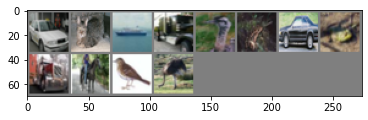

  car   cat  ship truck  bird  frog   car  frog truck horse  bird  bird


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Data Preparation


### 2. Build an MLP model

In [6]:
# from pytorch tutorial (see resources)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# modified from Net2 in medium article (see resources)
class Net3(nn.Module):
    '''a two-layer linear model 
      dropout: with default dropout = True
      do_const: with default dropout countant = 0.2
      hidden: with a default hidden dimension = 100
    '''

    def __init__(self, hidden=100, dropout=True, do_const=0.2):
        super(Net3,self).__init__()

        # characteristics of input
        dim_1 = 32 # x dimensions of the figure
        dim_2 = 32 # y dimensions of the figure
        num_classes = 10 # number of output classes
        num_col = 3 # since color images, for greyscale = 1

        # number of hidden nodes in each layer
        self.hidden_1  = hidden # hidden layer dimension (user defined)
        self.hidden_2  = hidden # hidden layer dimension (user defined)

        # dropout
        self.dropout = dropout       
        self.do_const = do_const

        # linear layer (num_col*dim_1 * dim_2 -> hidden_1) *NOTE Adding num_col very important for avoiding batch size errors
        self.fc1 = nn.Linear(3*32*32, self.hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(self.hidden_1,self.hidden_2)
        # linear layer (n_hidden -> num_classes)
        self.fc3 = nn.Linear(self.hidden_2,10)
        
        # optional dropout
        if self.dropout:
          # dropout layer (p=self.do_const)
          # dropout prevents overfitting of data
          self.droput = nn.Dropout(p=self.do_const)
        else:
          self.droput = nn.Dropout(p=0)
        
    def forward(self,x):
        # print(x.shape)
        # flatten image input (-1, num_col*dim_1*dim_2) *NOTE Adding num_col very important for avoiding batch size errors
        x = x.view(-1,3*32*32)
        # print(x.shape)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))

        # optional dropout
        if self.dropout:
          # add dropout layer
          x = self.droput(x)
        else:
          x = self.droput(x)
    
        # add output layer
        x = self.fc3(x)
        return x


### 3. Train each model
* Prelim - Create a pandas array to store all the information re: training and testing
* Prelim - Define a loss function and optimizer

4. First, train the simplest neural net
  * with regularization
  * without regularization
5. Then, test the more complicated neural net (with convolution)
  * with regularization 
  * without regularization
6. Save the data

In [7]:
# Prelim - Create a pandas array to store all the information re: training and testing
model_df = pd.DataFrame(columns=['model_name', 'net', 'train_err', 'test_error', 'model_dict', 'optim_dict'])

### Prelim

In [53]:
# Prelim define loss function, optimizer, and other hyperparameters
lr = 0.001
momentum = 0.9
n_epochs = 5

# L2
L2_penalty = True # the L2 penalty is par tof the optimizer
L2_constant = 1e-2 # some L2 constant > 0

# dropout
dropout=False
do_const=0.5

# hidden layers
hidden = 50

# set up net
net_in = Net3(hidden=hidden, dropout=dropout, do_const=do_const)
print(net_in)

# controls optimization
criterion = nn.CrossEntropyLoss()
if L2_penalty: # add regularization if desired
  optimizer = optim.SGD(net_in.parameters(), lr=0.001, momentum=0.9, weight_decay=L2_constant)
else:
  optimizer = optim.SGD(net_in.parameters(), lr=0.001, momentum=0.9, weight_decay=0)

# assembles list of loss for plotting
loss_list = []

# creates model name
model_name = str(hidden)+'HLN+'+'L2='+str(L2_penalty)
print(model_name)

Net3(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (droput): Dropout(p=0, inplace=False)
)
50HLN+L2=True


### 4. Train the neural Net

1.7955943031260673
1.5903667818309593
1.5236713025384492
1.4848844187081118
1.4606699741808085
Finished Training


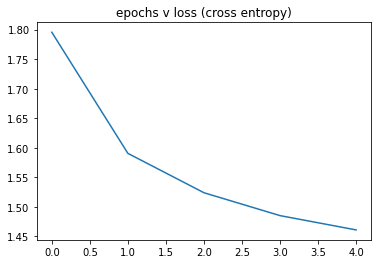

In [54]:
# training
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0 # keep track of loss within each epoch

    for i, data in enumerate(train_loader, 0): # loop through batches in train
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_in(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update loss statistics
        running_loss += loss.item()

    # print and save loss statistics
    print(running_loss / i)
    loss_list.append(running_loss / i)
    running_loss = 0.0


# final things
print('Finished Training')

# save some results

# plot
plt.plot(np.arange(0,len(loss_list)), loss_list)
plt.title('epochs v loss (cross entropy)')
plt.show()
      


### 5. test and
### 6. save

In [55]:
# train
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net_in(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# create train error, where train error is the percent mis-identified (expressed as a float between 0 and 1)
train_err = 1 - (correct / total)

# test
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_in(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# create test error, where test error is the percent mis-identified (expressed as a float between 0 and 1)
test_err = 1 - (correct / total)

In [58]:
model_df = model_df.append({'model_name': model_name, 'net': net_in, 
                            'train_err': train_err, 'test_error': test_err, 'model_dict': net_in.state_dict(), 'optim_dict': optimizer.state_dict()}, ignore_index=True)

PLOT 

In [80]:
 model_df[['model_name', 'train_err', 'test_error', 'L2_penalty', 'num_nodes', 'num_layers']].sort_index()

,model_name,train_err,test_error,L2_penalty,num_nodes,num_layers
1,200HLN+L2=False,0.39780,0.4666,0.00,200,2
2,200HLN+L2=True,0.47864,0.5067,0.01,200,2
3,200HLN+L2=True,0.90000,0.9000,0.50,200,2
4,50HLN+L2=False,0.45254,0.4956,0.00,50,2
5,50HLN+L2=True,0.49738,0.5181,0.01,50,2
6,50HLN+L2=True,0.90000,0.9000,0.50,50,2
7,50HLN+L2=True,0.90000,0.9000,0.50,50,2
8,5HLN+L2=False,0.65572,0.6646,0.00,5,2


In [98]:
i = 0
for model in model_df['model_dict']:
  i = i + 1
  print('Model', i)
  for param_tensor in model:
      print(param_tensor, "\t", model[param_tensor].size())
  
  print()


i = 0
for optimizer in model_df['optim_dict']:
  i = i + 1
  print('Model', i)
  for var_name in optimizer:
      if var_name == 'state':
        a = 1
      else:
        print((var_name), "\t", optimizer[var_name])
  
  print()


Model 1
fc1.weight 	 torch.Size([200, 3072])
fc1.bias 	 torch.Size([200])
fc2.weight 	 torch.Size([200, 200])
fc2.bias 	 torch.Size([200])
fc3.weight 	 torch.Size([10, 200])
fc3.bias 	 torch.Size([10])

Model 2
fc1.weight 	 torch.Size([200, 3072])
fc1.bias 	 torch.Size([200])
fc2.weight 	 torch.Size([200, 200])
fc2.bias 	 torch.Size([200])
fc3.weight 	 torch.Size([10, 200])
fc3.bias 	 torch.Size([10])

Model 3
fc1.weight 	 torch.Size([200, 3072])
fc1.bias 	 torch.Size([200])
fc2.weight 	 torch.Size([200, 200])
fc2.bias 	 torch.Size([200])
fc3.weight 	 torch.Size([10, 200])
fc3.bias 	 torch.Size([10])

Model 4
fc1.weight 	 torch.Size([50, 3072])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([50, 50])
fc2.bias 	 torch.Size([50])
fc3.weight 	 torch.Size([10, 50])
fc3.bias 	 torch.Size([10])

Model 5
fc1.weight 	 torch.Size([50, 3072])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([50, 50])
fc2.bias 	 torch.Size([50])
fc3.weight 	 torch.Size([10, 50])
fc3.bias 	 torch.Size([10]

### BONUS. Fun extra tests

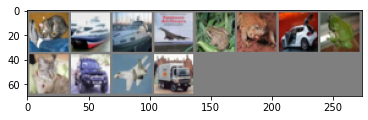

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck
Predicted:    cat truck plane  bird  deer  frog   cat  frog   dog   car plane truck

 Accuracy of the network on the 10000 test images: 53 %

Accuracy of plane : 61 %
Accuracy of   car : 61 %
Accuracy of  bird : 31 %
Accuracy of   cat : 36 %
Accuracy of  deer : 44 %
Accuracy of   dog : 41 %
Accuracy of  frog : 59 %
Accuracy of horse : 66 %
Accuracy of  ship : 69 %
Accuracy of truck : 61 %


In [13]:
# # check that test data are set up
# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# # preliminary check
# outputs = net_in(images)
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(batch_size)))

# # final check
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         outputs = net_in(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('\n Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

# # What are the classes that performed well, and the classes that did not perform well:
# print('')
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         outputs = net_in(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))